In [ ]:
 torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "/content/drive/MyDrive/IndianPines.csv"
df = pd.read_csv(file_path)

# Extract Features and Labels
X = df.iloc[:, :-1].values  # First 200 columns as features
y = df.iloc[:, -1].values   # Last column as labels

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)import numpy as np
import pandas as pd
import

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for episode in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        print(f"Episode {episode + 1}: Selected Classes -> {selected_classes}")  # Print selected classes

        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(X[selected_indices[:k_shot]])
            query_set.append(X[selected_indices[k_shot:]])

            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

# Define Few-Shot Dataset Parameters
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500

# Create Few-Shot Training Data
few_shot_data = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)

# Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 200, 128)  # Flattened feature output

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 200) -> (batch, 1, 200)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Ensure correct shape before computing distances
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])

        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Initialize Model and Optimizer
model = PrototypicalNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_few_shot_model(model, data, optimizer, criterion, epochs=100):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            support_y = torch.tensor(support_y, dtype=torch.long, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x)
            loss = criterion(outputs, query_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

        epoch_loss = total_loss / len(data)
        epoch_acc = total_correct / total_samples * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Evaluation Function with Class-Wise Accuracy
def evaluate_few_shot_model(model, data):
    model.eval()
    total_correct = 0
    total_samples = 0
    class_correct = {}
    class_total = {}

    with torch.no_grad():
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            outputs = model(support_x, query_x)
            preds = outputs.argmax(dim=1)

            total_correct += (preds == query_y).sum().item()
            total_samples += query_y.size(0)

            # Class-wise calculation
            for label in torch.unique(query_y):
                label = label.item()
                class_correct[label] = class_correct.get(label, 0) + (preds[query_y == label] == label).sum().item()
                class_total[label] = class_total.get(label, 0) + (query_y == label).sum().item()

    # Print Class-Wise Accuracy
    print("\nClass-Wise Accuracy:")
    for cls in sorted(class_correct.keys()):
        acc = (class_correct[cls] / class_total[cls]) * 100 if class_total[cls] > 0 else 0
        print(f"Class {cls}: {acc:.2f}%")

    # Print Overall Accuracy
    overall_accuracy = total_correct / total_samples * 100
    print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

# Train and Evaluate Model
if torch.cuda.is_available():
    print("Training on CUDA...")
    train_few_shot_model(model, few_shot_data, optimizer, criterion, epochs=300)
    evaluate_few_shot_model(model, few_shot_data)
else:
    print("Training on CPU (slower).")
    train_few_shot_model(model, few_shot_data, optimizer, criterion, epochs=150)
    evaluate_few_shot_model(model, few_shot_data)

Using device: cuda
Episode 1: Selected Classes -> [ 7  3 16  9 12]
Episode 2: Selected Classes -> [ 3 12  1  2  0]
Episode 3: Selected Classes -> [ 2 14 13 11 15]
Episode 4: Selected Classes -> [11 16  3  2 13]
Episode 5: Selected Classes -> [ 2  1 10  5 12]
Episode 6: Selected Classes -> [13 11  1 14  8]
Episode 7: Selected Classes -> [ 3 12  5  2 16]
Episode 8: Selected Classes -> [16  6  8  5  1]
Episode 9: Selected Classes -> [ 4 10 13  5 12]
Episode 10: Selected Classes -> [ 8  7  9 16 15]
Episode 11: Selected Classes -> [ 4 10 14  5  7]
Episode 12: Selected Classes -> [8 9 2 3 6]
Episode 13: Selected Classes -> [ 6  9  1 16 15]
Episode 14: Selected Classes -> [ 0 11  3 15 10]
Episode 15: Selected Classes -> [ 7 12 13  0 10]
Episode 16: Selected Classes -> [12 14  6  8  4]
Episode 17: Selected Classes -> [14  6 13  7  3]
Episode 18: Selected Classes -> [11  3 14  9 12]
Episode 19: Selected Classes -> [10  3  4  7  1]
Episode 20: Selected Classes -> [15  8 16 12  2]
Episode 21: Sel

Using device: cuda
Episode 1: Selected Classes -> [ 9  8 16 12 14]
Episode 2: Selected Classes -> [ 7 13  5  9 14]
Episode 3: Selected Classes -> [ 9  7 15  3 10]
Episode 4: Selected Classes -> [16  2  3  7  4]
Episode 5: Selected Classes -> [ 3  2  4 11  8]
Episode 6: Selected Classes -> [ 5  8 13  1  9]
Episode 7: Selected Classes -> [12  2 13 14 10]
Episode 8: Selected Classes -> [ 5 13 12  8  4]
Episode 9: Selected Classes -> [ 0  7 16  6 15]
Episode 10: Selected Classes -> [ 6  8  3 15  7]
Episode 11: Selected Classes -> [ 5 12  4 16 13]
Episode 12: Selected Classes -> [ 2  5 11  6 10]
Episode 13: Selected Classes -> [ 5  8 13 15 11]
Episode 14: Selected Classes -> [12  2  0  5  1]
Episode 15: Selected Classes -> [ 0  7 11  1 12]
Episode 16: Selected Classes -> [10  4  3 14 15]
Episode 17: Selected Classes -> [ 5  3  8 13  9]
Episode 18: Selected Classes -> [14  7  9  5 15]
Episode 19: Selected Classes -> [12 10 16  9  0]
Episode 20: Selected Classes -> [ 5  7  3 16 12]
Episode 21

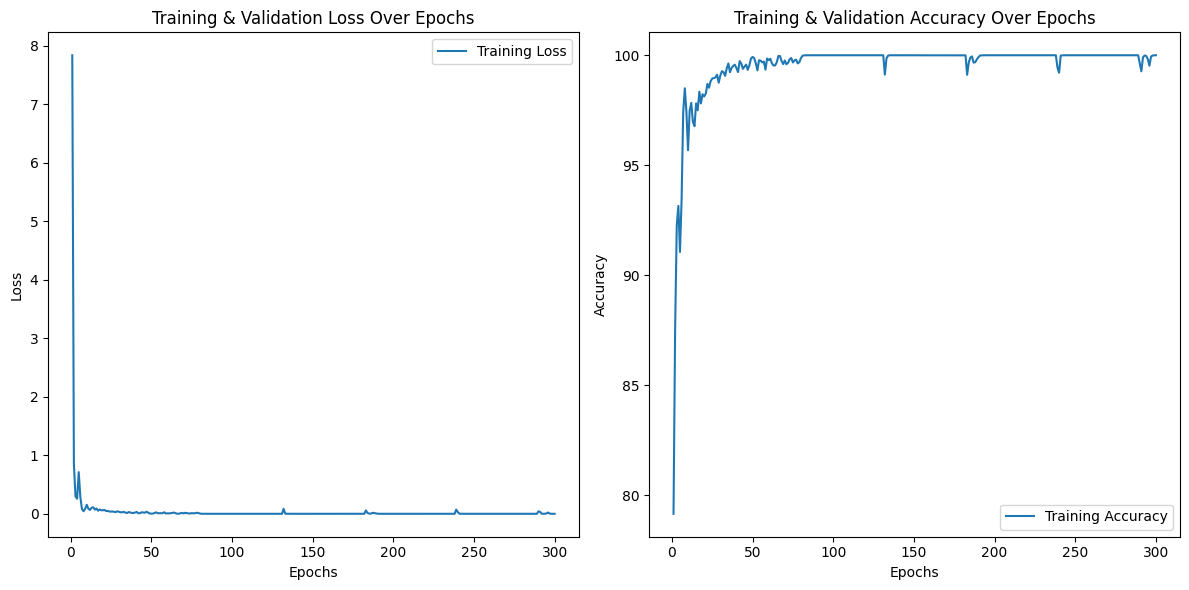

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "/content/drive/MyDrive/IndianPines.csv"
df = pd.read_csv(file_path)

# Extract Features and Labels
X = df.iloc[:, :-1].values  # First 200 columns as features
y = df.iloc[:, -1].values   # Last column as labels

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for episode in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        print(f"Episode {episode + 1}: Selected Classes -> {selected_classes}")  # Print selected classes

        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(X[selected_indices[:k_shot]])
            query_set.append(X[selected_indices[k_shot:]])

            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

# Define Few-Shot Dataset Parameters
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500

# Create Few-Shot Training Data
few_shot_data = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)

# Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 200, 128)  # Flattened feature output

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 200) -> (batch, 1, 200)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Ensure correct shape before computing distances
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])

        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Initialize Model and Optimizer
model = PrototypicalNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Track loss, accuracy, and training time
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training Function
def train_few_shot_model(model, data, optimizer, criterion, epochs=100):
    start_time = time.time()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            support_y = torch.tensor(support_y, dtype=torch.long, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x)
            loss = criterion(outputs, query_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

        epoch_loss = total_loss / len(data)
        epoch_acc = total_correct / total_samples * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time: {training_time:.2f} seconds")

    # Memory Usage
    if torch.cuda.is_available():
        memory_usage = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert bytes to MB
        print(f"GPU Memory Usage: {memory_usage:.2f} MB")

# Evaluation Function with Class-Wise Accuracy
def evaluate_few_shot_model(model, data):
    model.eval()
    total_correct = 0
    total_samples = 0
    class_correct = {}
    class_total = {}

    with torch.no_grad():
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            outputs = model(support_x, query_x)
            preds = outputs.argmax(dim=1)

            total_correct += (preds == query_y).sum().item()
            total_samples += query_y.size(0)

            # Class-wise calculation
            for label in torch.unique(query_y):
                label = label.item()
                class_correct[label] = class_correct.get(label, 0) + (preds[query_y == label] == label).sum().item()
                class_total[label] = class_total.get(label, 0) + (query_y == label).sum().item()

    # Print Class-Wise Accuracy
    print("\nClass-Wise Accuracy:")
    for cls in sorted(class_correct.keys()):
        acc = (class_correct[cls] / class_total[cls]) * 100 if class_total[cls] > 0 else 0
        print(f"Class {cls}: {acc:.2f}%")

    # Print Overall Accuracy
    overall_accuracy = total_correct / total_samples * 100
    print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

# Train and Evaluate Model
if torch.cuda.is_available():
    print("Training on CUDA...")
    train_few_shot_model(model, few_shot_data, optimizer, criterion, epochs=300)
    evaluate_few_shot_model(model, few_shot_data)
else:
    print("Training on CPU (slower).")
    train_few_shot_model(model, few_shot_data, optimizer, criterion, epochs=150)
    evaluate_few_shot_model(model, few_shot_data)

# Plot Loss and Accuracy
epochs = range(1, len(train_losses) + 1)


# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Episode 1: Selected Classes -> [ 3 13  9  0  6]
Episode 2: Selected Classes -> [ 9  0 13 10 12]
Episode 3: Selected Classes -> [ 2  9 11  7 13]
Episode 4: Selected Classes -> [ 2 13  9 11  6]
Episode 5: Selected Classes -> [10 16  8 15 14]
Episode 6: Selected Classes -> [ 7  8  9  6 16]
Episode 7: Selected Classes -> [ 9  5  6 13  3]
Episode 8: Selected Classes -> [ 3  4  8 12  6]
Episode 9: Selected Classes -> [ 3 10  5 13  1]
Episode 10: Selected Classes -> [ 4  9 14  5 16]
Episode 11: Selected Classes -> [ 1 10  6 16  3]
Episode 12: Selected Classes -> [12  5  2  6 15]
Episode 13: Selected Classes -> [ 6 15  8  0 10]
Episode 14: Selected Classes -> [16 15  5  4  9]
Episode 15: Selected Classes -> [ 3  2  7  1 14]
Episode 16: Selected Classes -> [10  4 11  7  9]
Episode 17: Selected Classes -> [ 8  7  9  2 12]
Episode 18: Selected Classes -> [13 10  2 12 11]
Episode 19: Selected Classes -> [10  0 12  7  1]
Episode 20: Selected Classes -> [14  7 12  6  9]
Episode 21

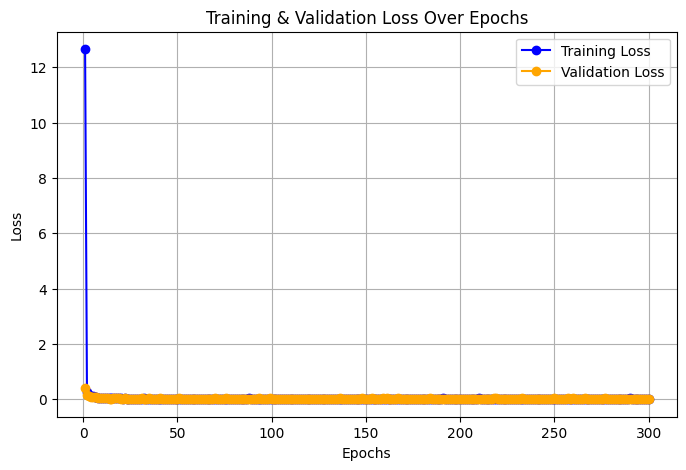

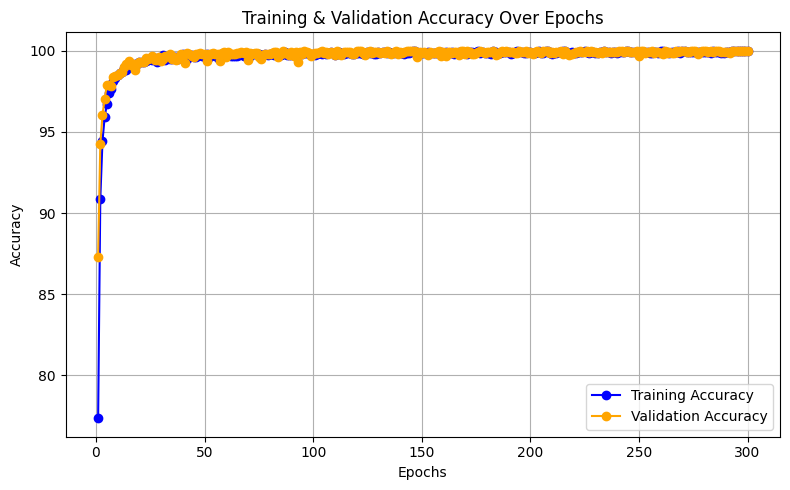

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "/content/drive/MyDrive/IndianPines.csv"
df = pd.read_csv(file_path)

# Extract Features and Labels
X = df.iloc[:, :-1].values  # First 200 columns as features
y = df.iloc[:, -1].values   # Last column as labels

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for episode in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        print(f"Episode {episode + 1}: Selected Classes -> {selected_classes}")  # Print selected classes

        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(X[selected_indices[:k_shot]])
            query_set.append(X[selected_indices[k_shot:]])

            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

# Define Few-Shot Dataset Parameters
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500

# Create Few-Shot Training Data
few_shot_data = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)

# Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 200, 128)  # Flattened feature output

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 200) -> (batch, 1, 200)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Ensure correct shape before computing distances
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])

        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Initialize Model and Optimizer
model = PrototypicalNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Track loss, accuracy, and training time
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training Function with Fixes
def train_few_shot_model(model, data, optimizer, criterion, epochs=100, validation_data=None):
    start_time = time.time()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            support_y = torch.tensor(support_y, dtype=torch.long, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x)

            # Debugging: Ensure loss computation is correct
            assert outputs.shape[0] == query_y.shape[0], f"Output shape {outputs.shape}, Labels shape {query_y.shape}"

            loss = criterion(outputs, query_y)
            loss.backward()

            # Gradient Clipping (Prevents instability)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

        epoch_loss = total_loss / len(data)
        epoch_acc = total_correct / total_samples * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Evaluate on validation data after each epoch
        if validation_data:
            valid_loss, valid_accuracy = evaluate_few_shot_model(model, validation_data)
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time: {training_time:.2f} seconds")

    if torch.cuda.is_available():
        memory_usage = torch.cuda.memory_allocated() / (1024 * 1024)
        print(f"GPU Memory Usage: {memory_usage:.2f} MB")

def evaluate_few_shot_model(model, data):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    class_correct = {}
    class_total = {}

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            outputs = model(support_x, query_x)
            preds = outputs.argmax(dim=1)

            loss = criterion(outputs, query_y)
            total_loss += loss.item()

            total_correct += (preds == query_y).sum().item()
            total_samples += query_y.size(0)

            for label in torch.unique(query_y):
                label = label.item()
                class_correct[label] = class_correct.get(label, 0) + (preds[query_y == label] == label).sum().item()
                class_total[label] = class_total.get(label, 0) + (query_y == label).sum().item()

    overall_accuracy = total_correct / total_samples * 100
    avg_loss = total_loss / len(data)  # Compute average loss over all batches

    return avg_loss, overall_accuracy  # Return actual computed values

# Train and Evaluate Model
if torch.cuda.is_available():
    print("Training on CUDA...")
    train_few_shot_model(model, few_shot_data, optimizer, criterion, epochs=300, validation_data=few_shot_data)
    evaluate_few_shot_model(model, few_shot_data)
else:
    print("Training on CPU (slower).")
    train_few_shot_model(model, few_shot_data, optimizer, criterion, epochs=150, validation_data=few_shot_data)
    evaluate_few_shot_model(model, few_shot_data)

# Plot Loss and Accuracy
epochs_range = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(epochs_range, valid_losses, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs_range, valid_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import os
import torch

# Define model directory and path
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_save_path = os.path.join(model_dir, "PrototypicalNetwork_IP.pth")

# Create directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/Model_Checkpoints/PrototypicalNetwork_IP.pth
